# BlaBlaCar Data Challenge

#### Author: Peter Martigny -- February 2017

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', False)
import matplotlib.pyplot as plt
%matplotlib inline
import time
import seaborn as sns

In [2]:
start = time.time()
print("Wait, I'm loading the dataset!")
data = pd.read_csv('dataset_datascientist_case_20161006.csv')
print('Done!\nLoading the dataset took me {} seconds'.format(time.time() - start))

Wait, I'm loading the dataset!


C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Done!
Loading the dataset took me 13.06165599822998 seconds


# Exploratory Analysis

In [3]:
# Size of data
print('The dataset contzins {} rows'.format(len(data)))
print('There are {} different drivers'.format(len(data.driver_id.unique())))
print('There are {} different offers'.format(len(data.offer_id.unique())))
print('There are {} different trips'.format(len(data.trip_id.unique())))
print("There are {} different dates of publication and {} different dates fro trips".format(len(data.published_date.unique()), len(data.trip_date.unique())) )

The dataset contzins 3379778 rows
There are 466211 different drivers
There are 704411 different offers
There are 3379778 different trips
There are 284 different dates of publication and 288639 different dates fro trips


#### Where do BlaBlaCar users come from?

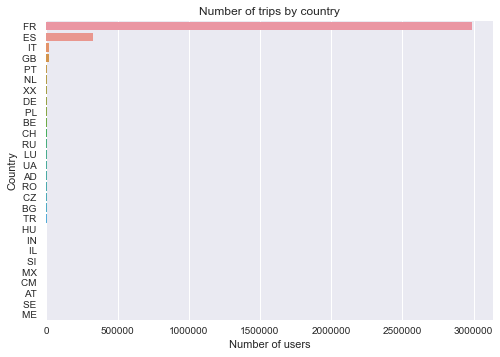

In [4]:
sorted_count = data.fixed_signup_country.value_counts()
sns.barplot(x=sorted_count.values, y=sorted_count.index)
plt.title('Number of trips by country')
plt.xlabel('Number of users')
plt.ylabel('Country')

del sorted_count

France is clearly the main market, with Spain having also a significant weight. Let's plot the same barplot after removing France and Spain:

In [5]:
data.fixed_signup_country.value_counts()

FR     2986190
ES      329593
IT       14397
GB       14304
PT        6194
NL        5534
XX        1200
DE        1154
PL         936
BE         708
CH         430
RU         250
LU          85
UA          64
AD          48
RO          32
CZ          29
BG          28
TR          26
HU          21
IN          19
IL          13
SI          11
MX           7
CM           3
AT           3
SE           2
ME           1
Name: fixed_signup_country, dtype: int64

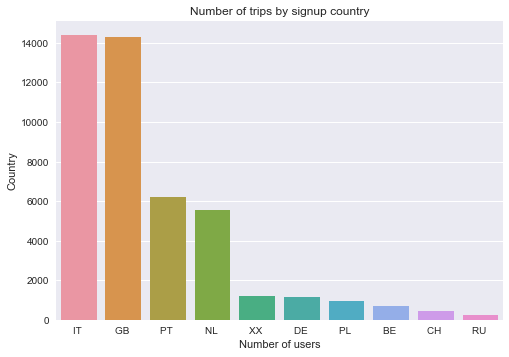

In [6]:
# Plot 10 main markets after FR and SP
sorted_count = data[~data.fixed_signup_country.isin(['FR ', 'ES '])].fixed_signup_country.value_counts()[:10]
sns.barplot(y=sorted_count.values, x=sorted_count.index)
plt.title('Number of trips by signup country')
plt.xlabel('Number of users')
plt.ylabel('Country')

del sorted_count

## Data Cleaning & Preprocessing

In [7]:
data.columns

Index(['driver_id', 'offer_id', 'trip_id', 'trip_date', 'published_date',
       'signup_date', 'fixed_signup_country', 'is_main_trip',
       'unit_seat_price_eur', 'seat_offered_count', 'seat_left_count',
       'confirmed_seat_count', 'trip_distance_km', 'from_lat', 'from_lon',
       'to_lat', 'to_lon', 'is_comfort', 'is_auto_accept_mode',
       'publication_site_id'],
      dtype='object')

In [8]:
start = time.time()
# Trip distance to be made into floats. Beware, very short trips (several kms) have commas!
print('Cleaning trip distance variable')
data['trip_distance_km'] = data['trip_distance_km'].apply(lambda x: float(x.replace(',', '.')))

# signup country must have its blank removed
# However, there are some NaN in this column
print('The rate of nans in the fixed_signup_country column is', 
      data['fixed_signup_country'].isnull().sum() / len(data))

# Remove nans for signup country :) and then remove the blanks
print('The number of rows that we remove is',
      data.shape[0] - data[~data['fixed_signup_country'].isnull()].shape[0])
print('Cleaning fixed signup country variable')
data = data[~data['fixed_signup_country'].isnull()]
data['fixed_signup_country'] = data['fixed_signup_country'].apply(lambda x: x.replace(' ', ''))

## We set to the 0 the negative elements for seat left counts
print('Cleaning seat left count variable')
data['seat_left_count'] = data['seat_left_count'].apply(lambda x: 0 if x < 0 else x)

# Change boolean columns to dummy variables
print('Creating dummy variable for is main trip')
data['is_main_trip'] = data['is_main_trip'].apply(lambda x: 1 if x == True else 0)
print('Creating dummy variable for is auto accept mode')
data['is_auto_accept_mode'] = data['is_auto_accept_mode'].apply(lambda x: 1 if x == True else 0)

# Clean unit_seat_price variable
# Beware tha some are str, some are float, and some str have both . and ,
print('Cleaning unit seat price variable')
data['unit_seat_price_eur'] = data['unit_seat_price_eur'].apply(str).apply(lambda x: x.replace(',', '')).apply(float)

# Clean trip distance and create per km price variable
print('Creating per km unit price variable')
data['trip_distance_km'] = data['trip_distance_km'].apply(lambda x: 1 if x == 0 else x)
data['per_km_price'] = data['unit_seat_price_eur'] / data['trip_distance_km']


from datetime import datetime, date, time, timedelta

# Change date format for all dates variables
print('Converting dates into correct format')
data['trip_date'] = data['trip_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
data['published_date'] = data['published_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
data['signup_date'] = data['signup_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

# Create a variable that says how many offers the driver has made until that date
print('Creating a variable for the number of past offers')
data['count_past_offers'] = data.sort_values('published_date').assign(x=1).groupby('driver_id')['x'].cumsum()[data.index]
# Create a variable that says the distance the driver has driven until that date
print('Creating a variable for cumulative distance')
data['cumulative_distance'] = data.sort_values('published_date').groupby('driver_id')['trip_distance_km'].cumsum()[data.index]


############################ Handle dates variables ###############################
print('Creating variables for year, month, day and hour of the trip day')
data['trip_date_year'] = data['trip_date'].apply(lambda x: x.year)
data['trip_date_month'] = data['trip_date'].apply(lambda x: x.month)
data['trip_date_day'] = data['trip_date'].apply(lambda x: x.day)
data['trip_date_hour'] = data['trip_date'].apply(lambda x: x.hour)

print('Creating variables for year, month, and day of the publication day')
data['published_date_year'] = data['published_date'].apply(lambda x: x.year)
data['published_date_month'] = data['published_date'].apply(lambda x: x.month)
data['published_date_day'] = data['published_date'].apply(lambda x: x.day)
# We don't create the hour variable since all publications here are made at midnight

print('Creating variables for year, month, day and hour of the signup day')
data['signup_date_year'] = data['signup_date'].apply(lambda x: x.year)
data['signup_date_month'] = data['signup_date'].apply(lambda x: x.month)
data['signup_date_day'] = data['signup_date'].apply(lambda x: x.day)
data['signup_date_hour'] = data['signup_date'].apply(lambda x: x.hour)


# Number of days between singup and publication offer
print('Creating a variable for the number of days since signup date')
data['driver_maturity'] = (data['published_date'] - data['signup_date']).apply(lambda x: x.days)

# Number of days between the publication and the trip
print('Creating a variable for the number of days between the publication and the trip')
data['time_laps'] = (data['trip_date'] - data['published_date']).apply(lambda x: x.days)

# Day in the week
print('Creating variables to give the day in the week for publication and trip day')
data['day_offer'] = data['published_date'].apply(lambda x: x.weekday())
data['day_trip'] = data['trip_date'].apply(lambda x: x.weekday())

########################### Geospatial data ##########################
import reverse_geocoder as rg

### Create features for departure locations ####
# Tuple containing all pairs of coordinates
coordinates = tuple(zip(data.from_lat, data.from_lon))
# Compute results
results = rg.search(coordinates)
# Create features
print("Wait, I'm finding the location info of the departures!")
data['departure_region'] = pd.Series([x['admin1'] for x in results])
data['departure_department'] = pd.Series([x['admin2'] for x in results])
data['departure_country'] = pd.Series([x['cc'] for x in results])
data['departure_city'] = pd.Series([x['name'] for x in results])

### Create features for arrival locations ####
coordinates = tuple(zip(data.to_lat, data.to_lon))
results = rg.search(coordinates)
print("Wait, I'm finding the location info of the arrival!")
data['arrival_region'] = pd.Series([x['admin1'] for x in results])
data['arrival_department'] = pd.Series([x['admin2'] for x in results])
data['arrival_country'] = pd.Series([x['cc'] for x in results])
data['arrival_city'] = pd.Series([x['name'] for x in results])

del coordinates

######################### Create the target variable: is the trip a success or not? #############
print('Creating the target variable')
data['target'] = data['confirmed_seat_count'].apply(lambda x: 1 if x > 0 else 0)

import time
print('Preprocessing is done! It took me {} seconds to finish the job!'.format(time.time() - start))

Cleaning trip distance variable
The rate of nans in the fixed_signup_country column is 0.00547254878871
The number of rows that we remove is 18496
Cleaning fixed signup country variable
Cleaning seat left count variable
Creating dummy variable for is main trip
Creating dummy variable for is auto accept mode
Cleaning unit seat price variable
Creating per km unit price variable
Converting dates into correct format
Creating a variable for the number of past offers
Creating a variable for cumulative distance
Creating variables for year, month, day and hour of the trip day
Creating variables for year, month, and day of the publication day
Creating variables for year, month, day and hour of the signup day
Creating a variable for the number of days since signup date
Creating a variable for the number of days between the publication and the trip
Creating variables to give the day in the week for publication and trip day
Loading formatted geocoded file...
Wait, I'm finding the location info of 

In [9]:
# Creating features that count how many offers have been made before, in both departure and 
# arrival cities, departments and regions
print('Creating a variable for cumulative past offers in the departure and arrival cities')
data['cumulative_departure_city'] = data.sort_values('published_date').assign(x=1).groupby('departure_city')['x'].cumsum()[data.index]
data['cumulative_arrival_city'] = data.sort_values('published_date').assign(x=1).groupby('arrival_city')['x'].cumsum()[data.index]

print('Creating a variable for cumulative past offers in the departure and arrival departments')
data['cumulative_departure_department'] = data.sort_values('published_date').assign(x=1).groupby('departure_department')['x'].cumsum()[data.index]
data['cumulative_arrival_department'] = data.sort_values('published_date').assign(x=1).groupby('arrival_department')['x'].cumsum()[data.index]

print('Creating a variable for cumulative past offers in the departure and arrival regions')
data['cumulative_departure_region'] = data.sort_values('published_date').assign(x=1).groupby('departure_region')['x'].cumsum()[data.index]
data['cumulative_arrival_region'] = data.sort_values('published_date').assign(x=1).groupby('arrival_region')['x'].cumsum()[data.index]

Creating a variable for cumulative past offers in the departure and arrival cities
Creating a variable for cumulative past offers in the departure and arrival departments
Creating a variable for cumulative past offers in the departure and arrival regions


In [10]:
data.cumulative_arrival_city.min()

0

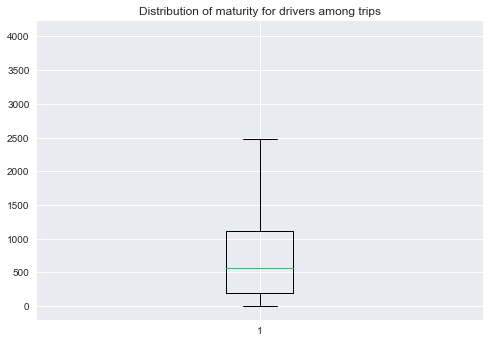

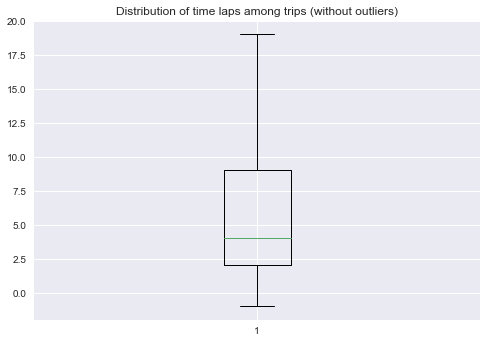

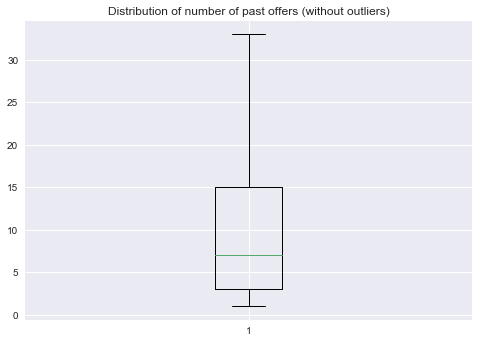

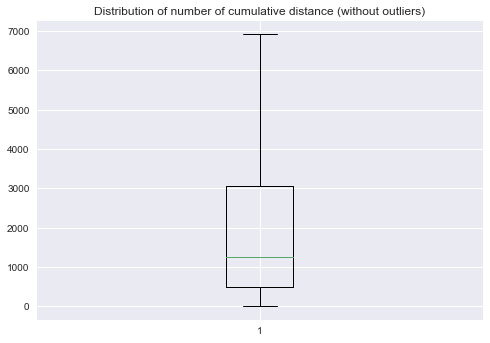

In [11]:
############### Boxplots ########################
plt.boxplot(data.driver_maturity)
plt.title('Distribution of maturity for drivers among trips')
plt.show()

plt.boxplot(data.time_laps, showfliers=False)
plt.title('Distribution of time laps among trips (without outliers)')
plt.show()

plt.boxplot(data.count_past_offers, showfliers=False)
plt.title('Distribution of number of past offers (without outliers)')
plt.show()

plt.boxplot(data.cumulative_distance, showfliers=False)
plt.title('Distribution of number of cumulative distance (without outliers)')
plt.show()

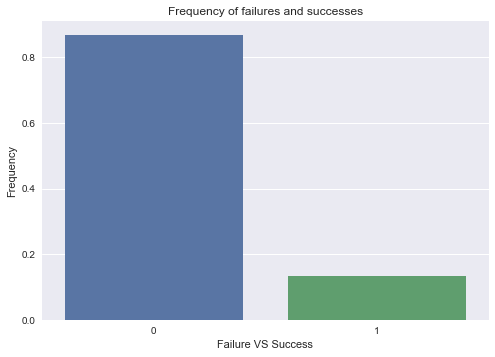

In [12]:
sorted_count = data.target.value_counts() / len(data)
sns.barplot(y=sorted_count.values, x=sorted_count.index)
plt.title('Frequency of failures and successes')
plt.xlabel('Failure VS Success')
plt.ylabel('Frequency')
plt.show()

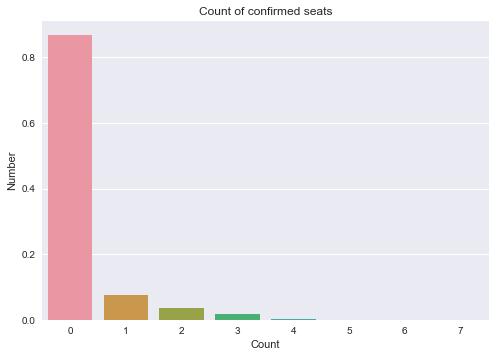

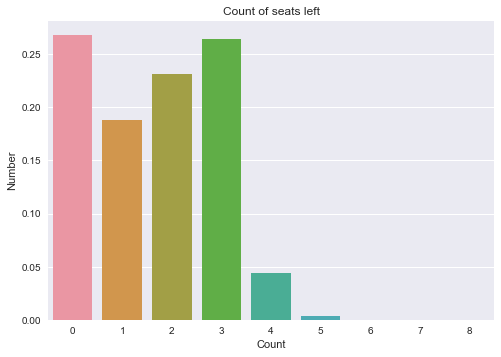

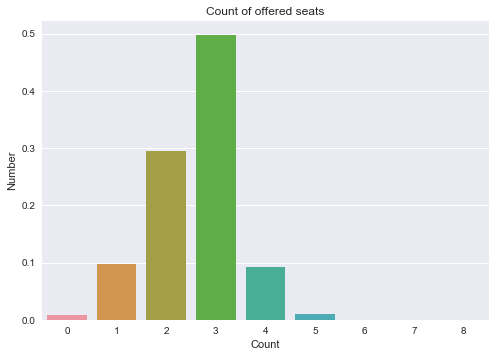

In [13]:
############### Barplots for number of seats variables ###########""
sorted_count = data.confirmed_seat_count.value_counts() / len(data)
sns.barplot(y=sorted_count.values, x=sorted_count.index)
plt.title('Count of confirmed seats')
plt.xlabel('Count')
plt.ylabel('Number')
plt.show()

sorted_count = data.seat_left_count.value_counts() / len(data)
sns.barplot(y=sorted_count.values, x=sorted_count.index)
plt.title('Count of seats left')
plt.xlabel('Count')
plt.ylabel('Number')
plt.show()

sorted_count = data.seat_offered_count.value_counts() / len(data)
sns.barplot(y=sorted_count.values, x=sorted_count.index)
plt.title('Count of offered seats')
plt.xlabel('Count')
plt.ylabel('Number')
plt.show()

del sorted_count

In [14]:
print(data.is_main_trip.value_counts())
print(data.is_comfort.value_counts()) # We will remove this feature
print(data.is_auto_accept_mode.value_counts())

0    2661376
1     699906
Name: is_main_trip, dtype: int64
False    3361282
Name: is_comfort, dtype: int64
0    1928808
1    1432474
Name: is_auto_accept_mode, dtype: int64


In [15]:
# There are 36 different platforms --> dummify this feature
pd.get_dummies(data.publication_site_id).head()
# Same for the country of signup (28 countries)
pd.get_dummies(data.fixed_signup_country).head()

,AD,AT,BE,BG,CH,CM,CZ,DE,ES,FR,GB,HU,IL,IN,IT,LU,ME,MX,NL,PL,PT,RO,RU,SE,SI,TR,UA,XX
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# DataViz: Effect of some variables on the success of the offer

#### Effect of the maturity of the driver

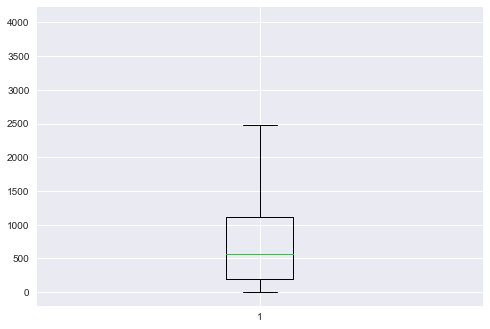

In [13]:
# Effect of mathurity
plt.boxplot(data.driver_maturity)
plt.show()

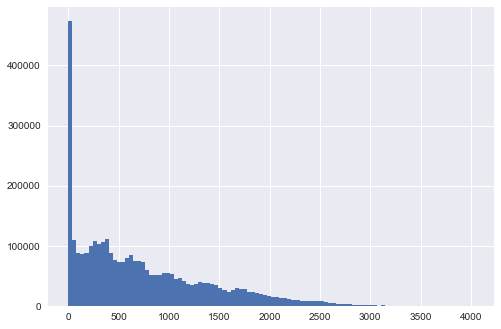

In [14]:
plt.hist(data.driver_maturity, bins=100)
plt.show()

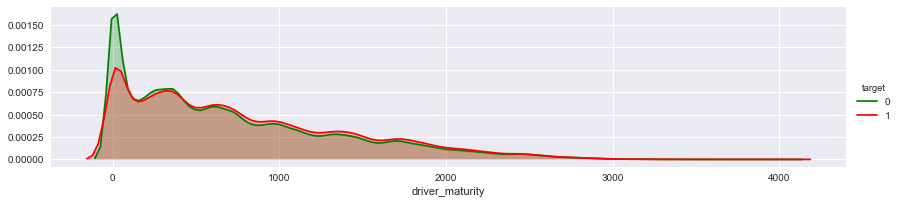

In [15]:
pal = ["g", "r"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'driver_maturity',shade= True)
facet.add_legend()

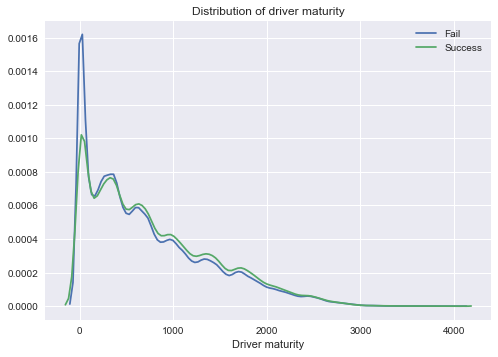

In [29]:
sns.kdeplot(data.driver_maturity[data.target == 0], label='Fail')
sns.kdeplot(data.driver_maturity[data.target == 1], label = 'Success')
plt.title('Distribution of driver maturity')
plt.xlabel('Driver maturity')
plt.show()

#### Effect of the number of past offers from the driver

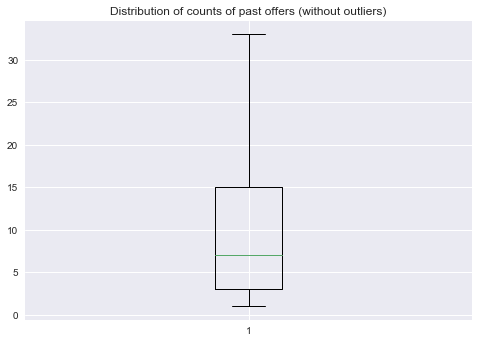

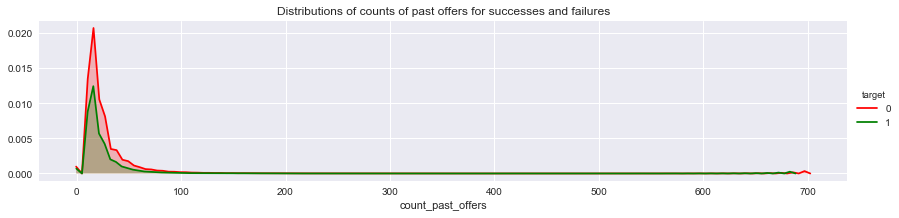

In [16]:
# Effect of number of past offers
plt.boxplot(data.count_past_offers, showfliers=False)
plt.title('Distribution of counts of past offers (without outliers)')
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'count_past_offers',shade= True)
plt.title('Distributions of counts of past offers for successes and failures')
facet.add_legend()
plt.show()

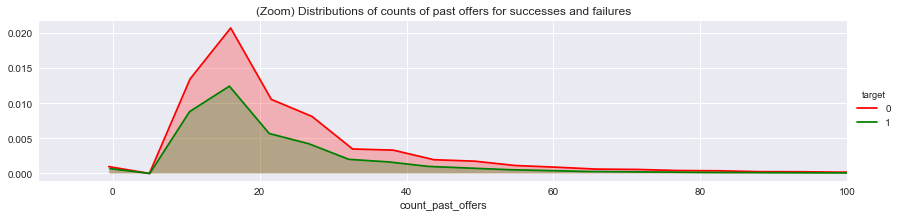

In [17]:
pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'count_past_offers',shade= True)
plt.title('(Zoom) Distributions of counts of past offers for successes and failures')
facet.add_legend()
plt.xlim([-10, 100])
plt.show()

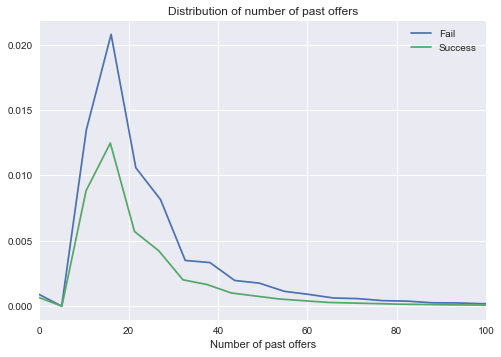

In [32]:
sns.kdeplot(data.count_past_offers[data.target == 0], label='Fail')
sns.kdeplot(data.count_past_offers[data.target == 1], label = 'Success')
plt.title('Distribution of number of past offers')
plt.xlabel('Number of past offers')
plt.xlim([0, 100])
plt.show()

We observe that having made more offers in the past does not necessarily lead to a higher probability of success, in fact it's rather the contrary. It is possible that driver with more offers are proposing more "regular trips" (like commuting) whereas users tend to need unusual trips.

#### Effect of the distance of the trip

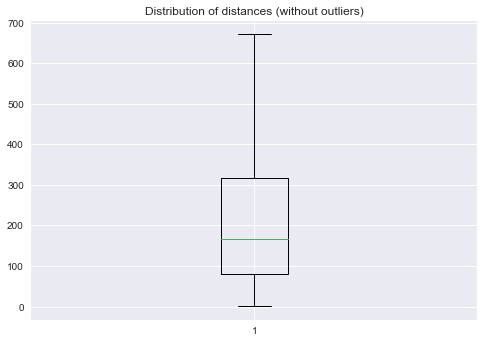

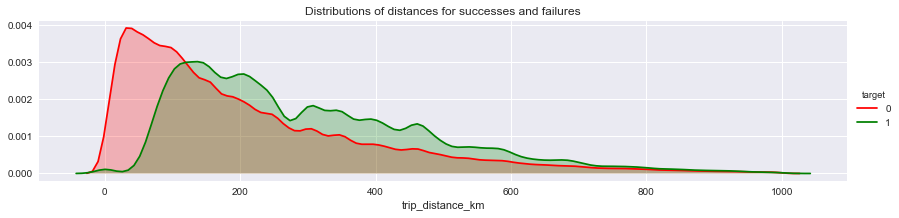

In [18]:
# Effect of distance
plt.boxplot(data.trip_distance_km, showfliers=False)
plt.title('Distribution of distances (without outliers)')
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'trip_distance_km',shade= True)
plt.title('Distributions of distances for successes and failures')
facet.add_legend()
plt.show()

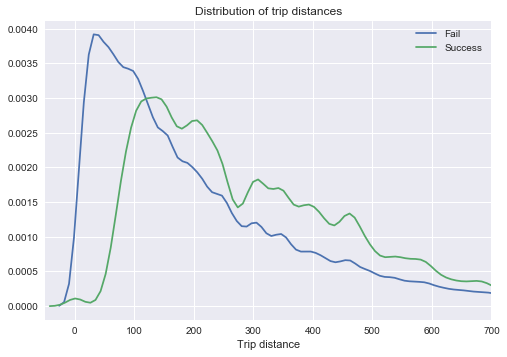

In [40]:
sns.kdeplot(data.trip_distance_km[data.target == 0], label='Fail')
sns.kdeplot(data.trip_distance_km[data.target == 1], label = 'Success')
plt.title('Distribution of trip distances')
plt.xlabel('Trip distance')
plt.xlim([-50, 700])
plt.show()

Here, we clearly see that longer trips have a higher probability to lead to a successful offer!

#### Effect of the time between offer and trip

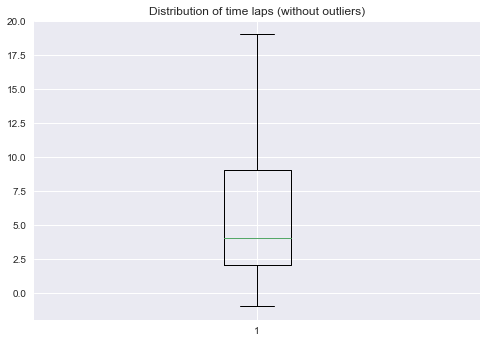

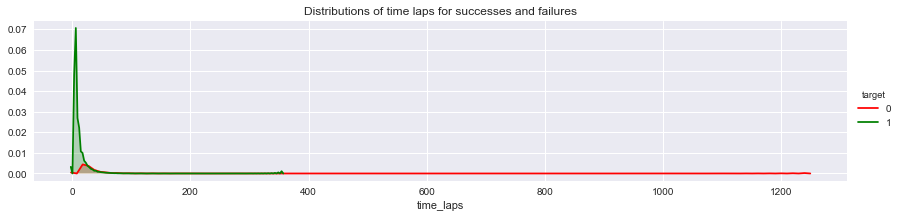

In [19]:
# Effect of time laps
plt.boxplot(data.time_laps, showfliers=False)
plt.title('Distribution of time laps (without outliers)')
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'time_laps',shade= True)
plt.title('Distributions of time laps for successes and failures')
facet.add_legend()
plt.show()

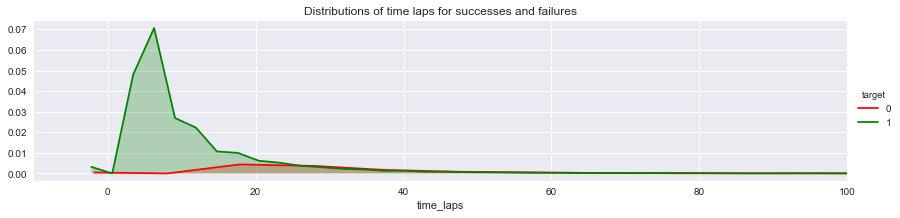

In [20]:
pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'time_laps',shade= True)
plt.title('Distributions of time laps for successes and failures')
facet.add_legend()
plt.xlim([-10, 100])
plt.show()

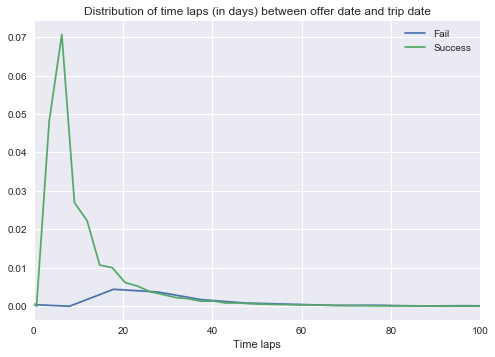

In [46]:
sns.kdeplot(data.time_laps[data.target == 0], label='Fail')
sns.kdeplot(data.time_laps[data.target == 1], label = 'Success')
plt.title('Distribution of time laps (in days) between offer date and trip date')
plt.xlabel('Time laps')
plt.xlim([0, 100])
plt.show()

We observe that offers which are posted only a few days before the trip tend to raise the probability to succeed!

#### Effect of the unit price

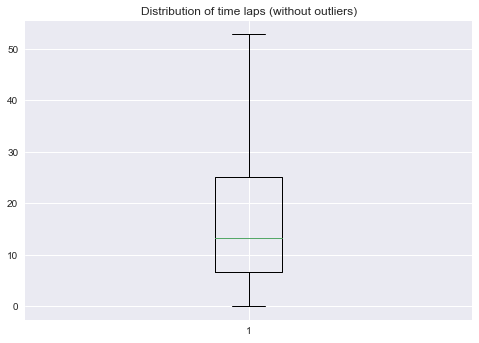

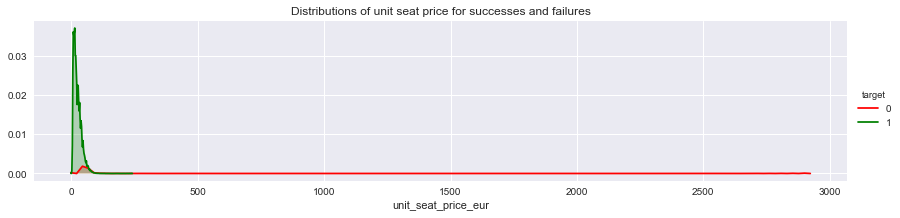

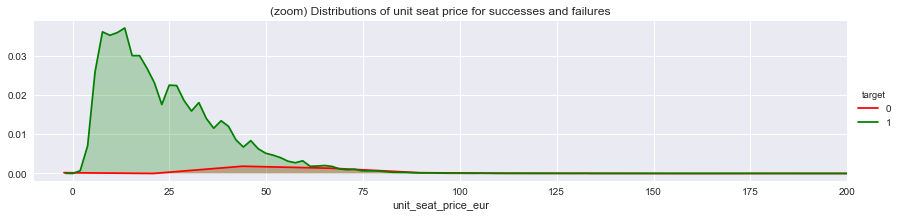

In [21]:
# Effect of unit seat price
plt.boxplot(data.unit_seat_price_eur, showfliers=False)
plt.title('Distribution of time laps (without outliers)')
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'unit_seat_price_eur',shade= True)
plt.title('Distributions of unit seat price for successes and failures')
facet.add_legend()
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'unit_seat_price_eur',shade= True)
plt.title('(zoom) Distributions of unit seat price for successes and failures')
facet.add_legend()
plt.xlim([-10, 200])
plt.show()

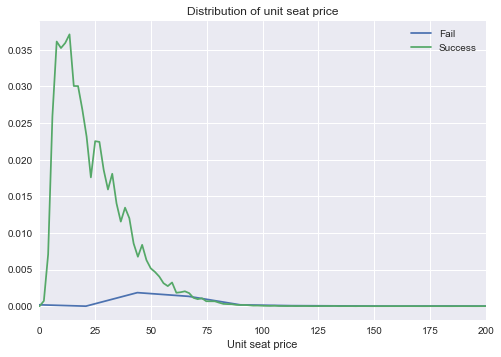

In [49]:
sns.kdeplot(data.unit_seat_price_eur[data.target == 0], label='Fail')
sns.kdeplot(data.unit_seat_price_eur[data.target == 1], label = 'Success')
plt.title('Distribution of unit seat price')
plt.xlabel('Unit seat price')
plt.xlim([0, 200])
plt.show()

Without surprise, the price is an important feature to predict the success of an offer!

#### Effect of the per km price

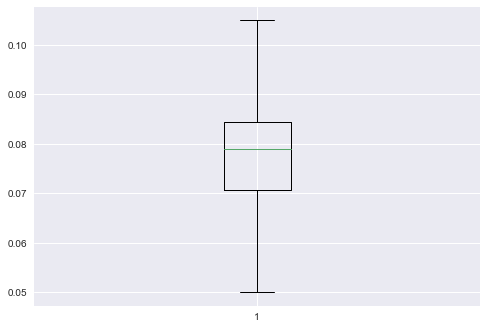

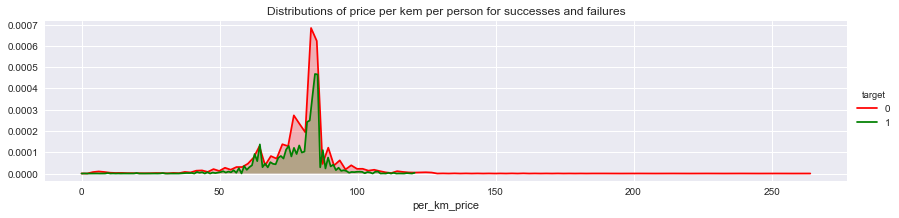

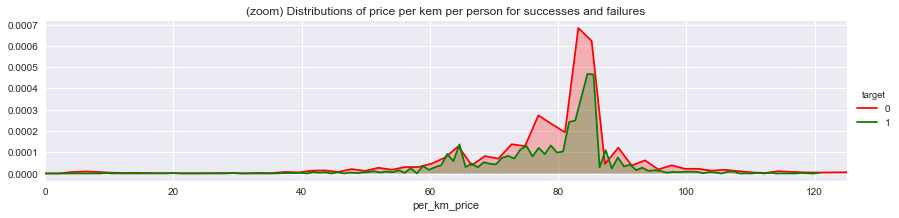

In [22]:
plt.boxplot(data.per_km_price, showfliers=False)
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'per_km_price',shade= True)
plt.title('Distributions of price per kem per person for successes and failures')
facet.add_legend()
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'per_km_price',shade= True)
plt.title('(zoom) Distributions of price per kem per person for successes and failures')
facet.add_legend()
plt.xlim([0, 125])
plt.show()

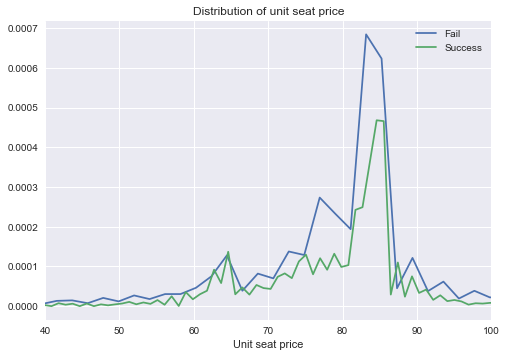

In [52]:
sns.kdeplot(data.per_km_price[data.target == 0], label='Fail')
sns.kdeplot(data.per_km_price[data.target == 1], label = 'Success')
plt.title('Distribution of unit seat price')
plt.xlabel('Unit seat price')
plt.xlim([40, 100])
plt.show()

There is no straightforward link between per km price and success.

#### Effect of the cumulative distance driven so far by the driver

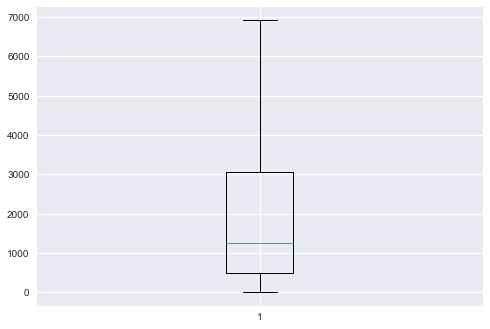

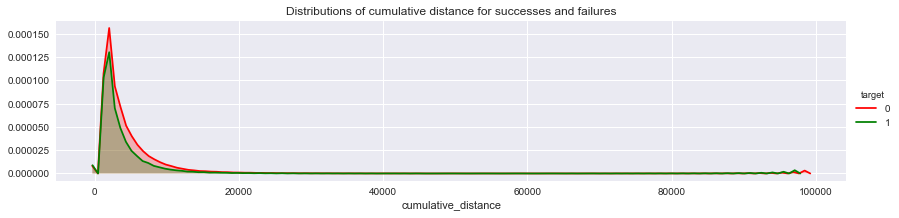

In [23]:
plt.boxplot(data.cumulative_distance, showfliers=False)
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'cumulative_distance',shade= True)
plt.title('Distributions of cumulative distance for successes and failures')
facet.add_legend()
plt.show()

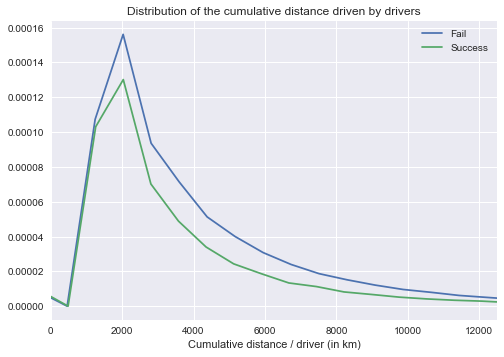

In [61]:
sns.kdeplot(data.cumulative_distance[data.target == 0], label='Fail')
sns.kdeplot(data.cumulative_distance[data.target == 1], label = 'Success')
plt.title('Distribution of the cumulative distance driven by drivers')
plt.xlabel('Cumulative distance / driver (in km)')
plt.xlim([0, 12500])
plt.show()

We remark a slight difference, with low cumulative distance having a little bit more chance to lead to a success.

#### Effect of automatic mode

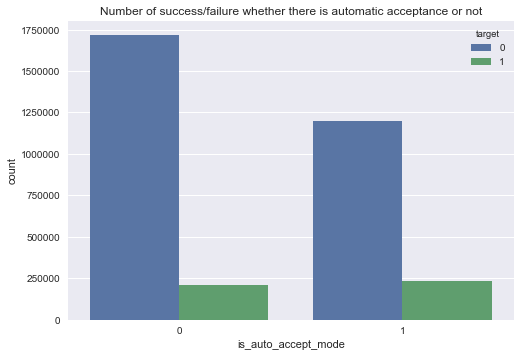

In [79]:
sns.countplot(x="is_auto_accept_mode", hue="target", data=data)
plt.title('Number of success/failure whether there is automatic acceptance or not')
plt.show()

We observe that for drivers with automatic mode, the probability of success is higher!

#### Effect of main trip or not

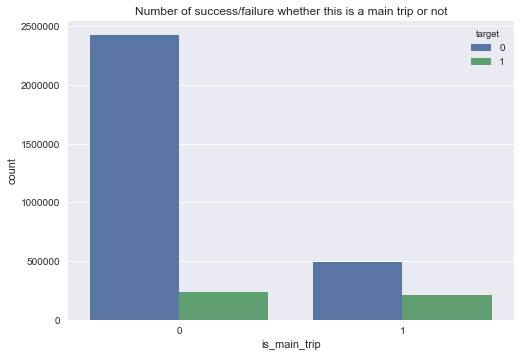

In [25]:
sns.countplot(x="is_main_trip", hue="target", data=data)
plt.title('Number of success/failure whether this is a main trip or not')
plt.show()

We observe that main trips have more successes than not-main trips (in proportion).

#### Effect of the publication platform

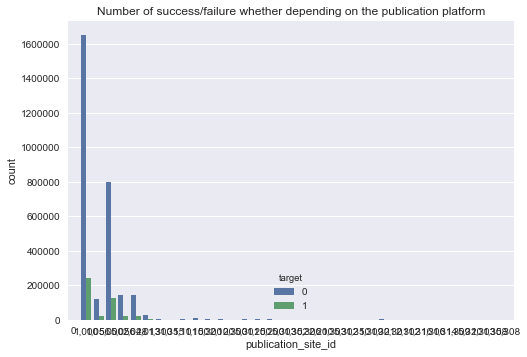

In [26]:
sns.countplot(x="publication_site_id", hue="target", data=data)
plt.title('Number of success/failure whether depending on the publication platform')
plt.show()

#### Effect of the signup country

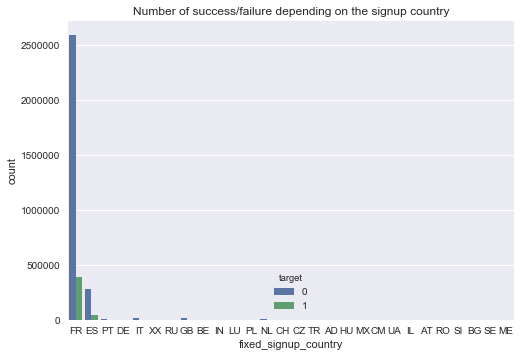

In [27]:
sns.countplot(x="fixed_signup_country", hue="target", data=data)
plt.title('Number of success/failure depending on the signup country')
plt.show()

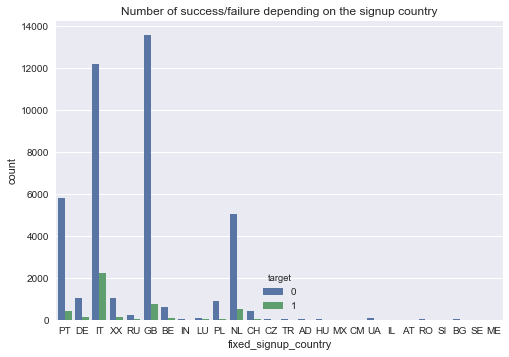

In [28]:
sns.countplot(x="fixed_signup_country", hue="target", data=data[~data.fixed_signup_country.isin(['FR', 'ES'])])
plt.title('Number of success/failure depending on the signup country')
plt.show()

#### Effect of the number of seats proposed

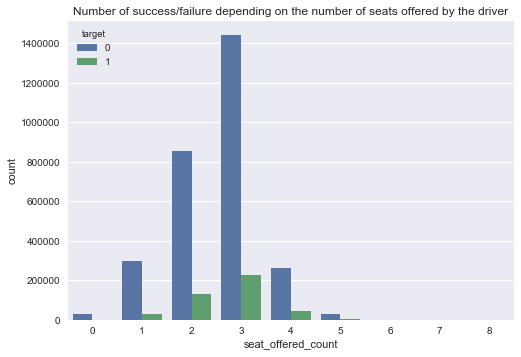

In [29]:
sns.countplot(x='seat_offered_count', hue="target", data=data)
plt.title('Number of success/failure depending on the number of seats offered by the driver')
plt.show()

#### Effect of the month

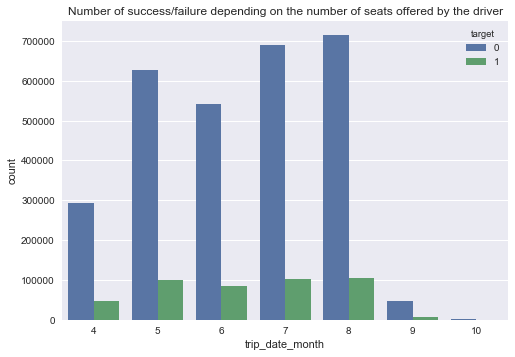

In [30]:
sns.countplot(x='trip_date_month', hue="target", data=data)
plt.title('Number of success/failure depending on the number of seats offered by the driver')
plt.show()

#### Effect of the day in the week

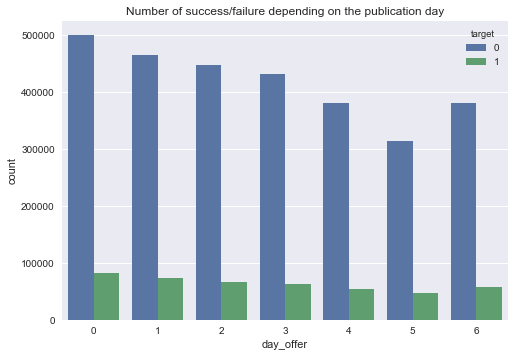

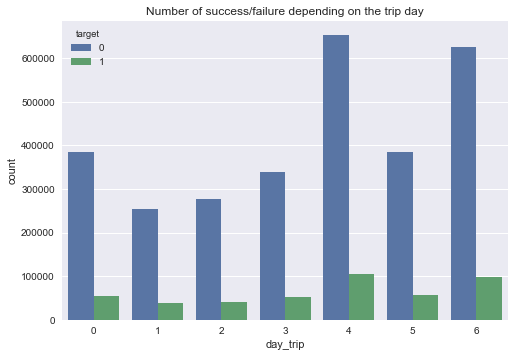

In [31]:
sns.countplot(x='day_offer', hue="target", data=data)
plt.title('Number of success/failure depending on the publication day')
plt.show()

sns.countplot(x='day_trip', hue="target", data=data)
plt.title('Number of success/failure depending on the trip day')
plt.show()

#### Effect of the day in the month

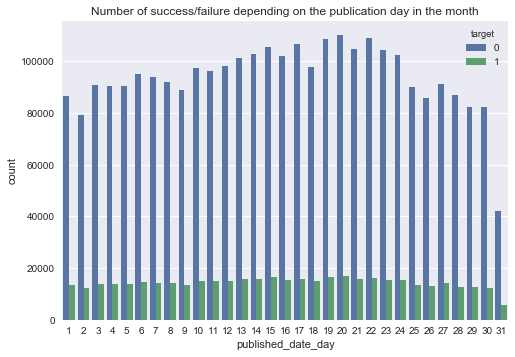

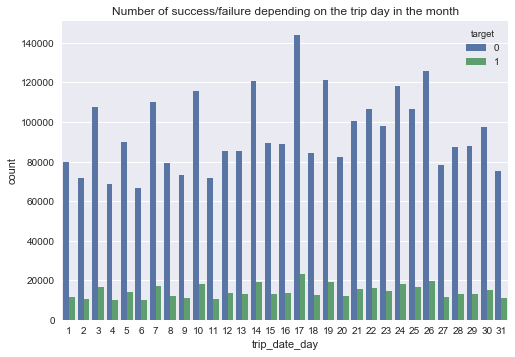

In [32]:
sns.countplot(x='published_date_day', hue="target", data=data)
plt.title('Number of success/failure depending on the publication day in the month')
plt.show()

sns.countplot(x='trip_date_day', hue="target", data=data)
plt.title('Number of success/failure depending on the trip day in the month')
plt.show()

#### Effect of the time

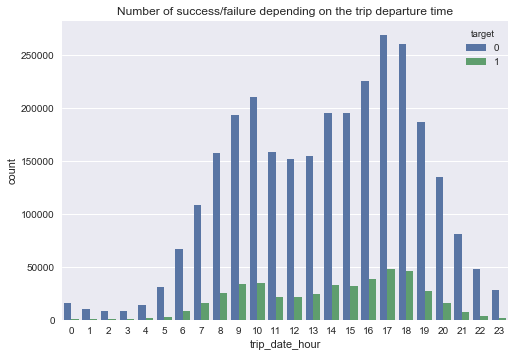

In [33]:
sns.countplot(x='trip_date_hour', hue="target", data=data)
plt.title('Number of success/failure depending on the trip departure time')
plt.show()

#### Geospatial data

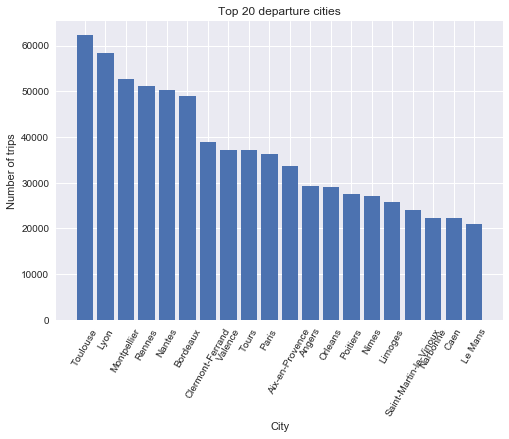

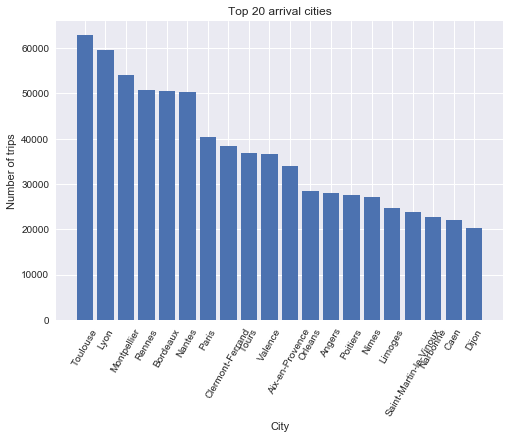

In [34]:
def plot_top_departure_cities(N):
    x = np.arange(N)
    xTicks = data.departure_city.value_counts()[:N].index
    y = data.departure_city.value_counts()[:N].values
    plt.xticks(x, xTicks)
    plt.xticks(range(N), xTicks, rotation=60)
    plt.bar(x,y)
    plt.title('Top {} departure cities'.format(N))
    plt.xlabel('City')
    plt.ylabel('Number of trips')
    plt.show()
    
def plot_top_arrival_cities(N):
    x = np.arange(N)
    xTicks = data.arrival_city.value_counts()[:N].index
    y = data.arrival_city.value_counts()[:N].values
    plt.xticks(x, xTicks)
    plt.xticks(range(N), xTicks, rotation=60)
    plt.bar(x,y)
    plt.title('Top {} arrival cities'.format(N))
    plt.xlabel('City')
    plt.ylabel('Number of trips')    
    plt.show()
plot_top_departure_cities(20)
plot_top_arrival_cities(20)

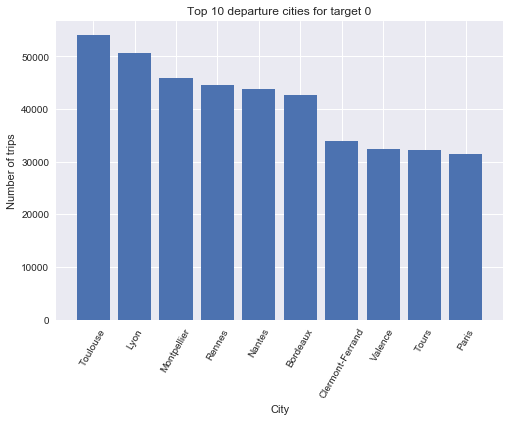

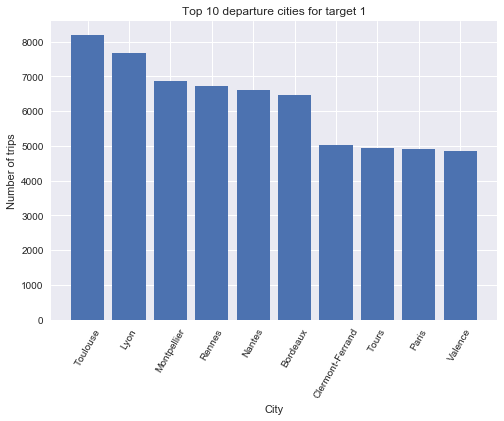

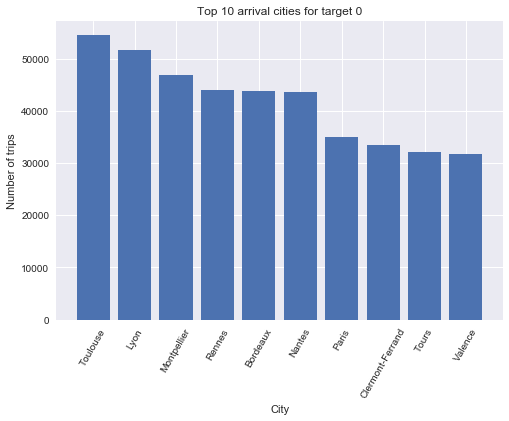

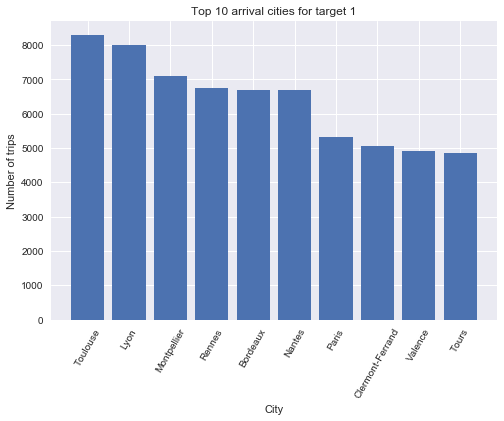

In [35]:
def plot_top_departure_cities(N, target):
    x = np.arange(N)
    xTicks = data[data.target == target].departure_city.value_counts()[:N].index
    y = data[data.target == target].departure_city.value_counts()[:N].values
    plt.xticks(x, xTicks)
    plt.xticks(range(N), xTicks, rotation=60)
    plt.bar(x,y)
    plt.title('Top {} departure cities for target {}'.format(N, target))
    plt.xlabel('City')
    plt.ylabel('Number of trips')
    plt.show()
    
def plot_top_arrival_cities(N, target):
    x = np.arange(N)
    xTicks = data[data.target == target].arrival_city.value_counts()[:N].index
    y = data[data.target == target].arrival_city.value_counts()[:N].values
    plt.xticks(x, xTicks)
    plt.xticks(range(N), xTicks, rotation=60)
    plt.bar(x,y)
    plt.title('Top {} arrival cities for target {}'.format(N, target))
    plt.xlabel('City')
    plt.ylabel('Number of trips')    
    plt.show()

# Differences between success and failure from departure city?
plot_top_departure_cities(10, 0)
plot_top_departure_cities(10, 1)

# Differences between success and failure from departure city?
plot_top_arrival_cities(10, 0)
plot_top_arrival_cities(10, 1)

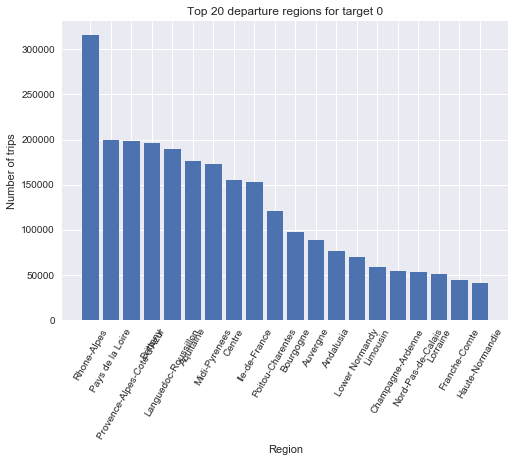

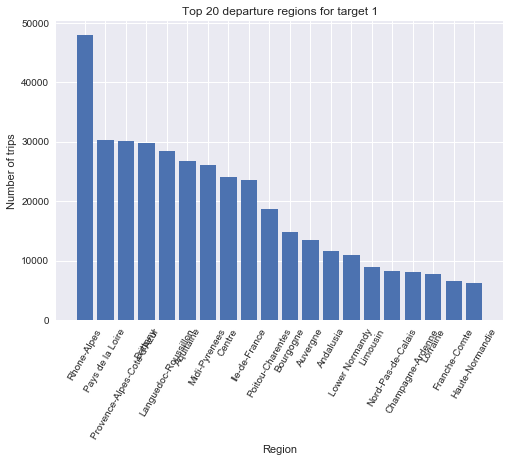

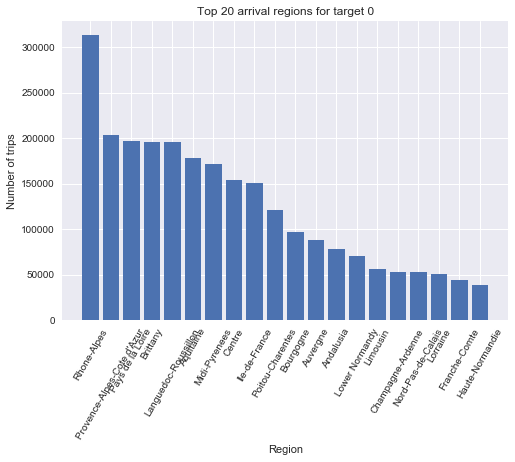

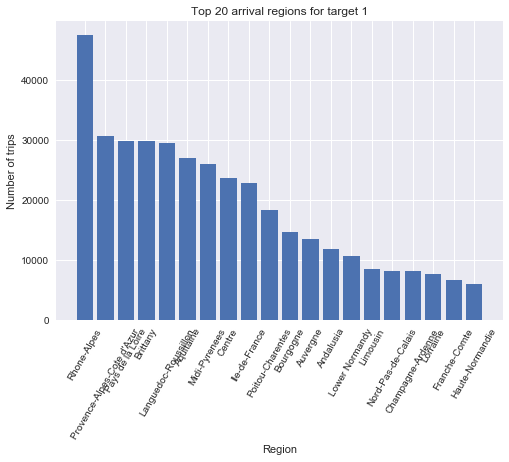

In [36]:
# Same for regions

def plot_top_departure_regions(N, target):
    x = np.arange(N)
    xTicks = data[data.target == target].departure_region.value_counts()[:N].index
    y = data[data.target == target].departure_region.value_counts()[:N].values
    plt.xticks(x, xTicks)
    plt.xticks(range(N), xTicks, rotation=60)
    plt.bar(x,y)
    plt.title('Top {} departure regions for target {}'.format(N, target))
    plt.xlabel('Region')
    plt.ylabel('Number of trips')
    plt.show()
    
def plot_top_arrival_regions(N, target):
    x = np.arange(N)
    xTicks = data[data.target == target].arrival_region.value_counts()[:N].index
    y = data[data.target == target].arrival_region.value_counts()[:N].values
    plt.xticks(x, xTicks)
    plt.xticks(range(N), xTicks, rotation=60)
    plt.bar(x,y)
    plt.title('Top {} arrival regions for target {}'.format(N, target))
    plt.xlabel('Region')
    plt.ylabel('Number of trips')    
    plt.show()
    
# Differences between success and failure from departure region?
plot_top_departure_regions(20, 0)
plot_top_departure_regions(20, 1)

# Differences between success and failure from departure region?
plot_top_arrival_regions(20, 0)
plot_top_arrival_regions(20, 1)

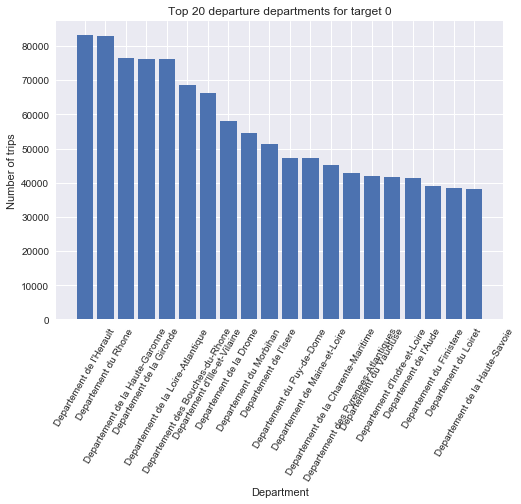

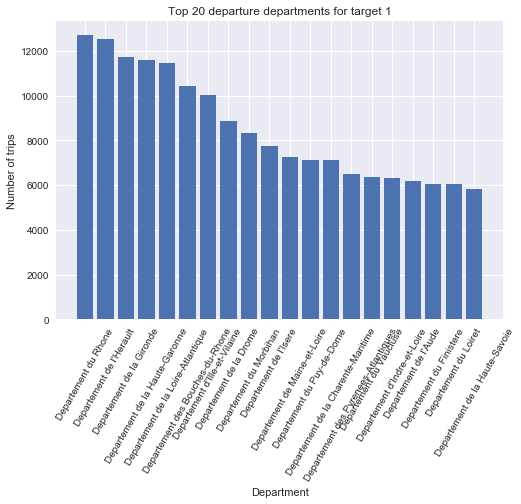

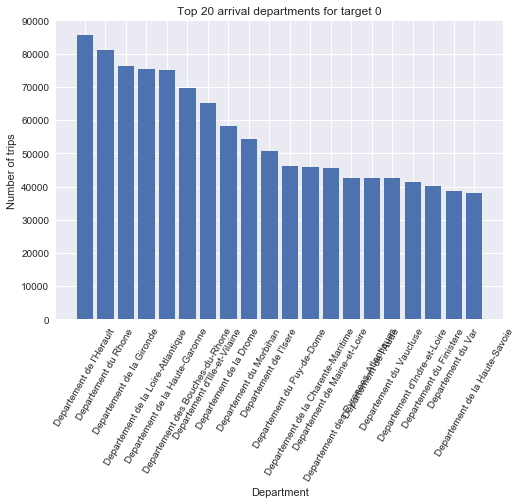

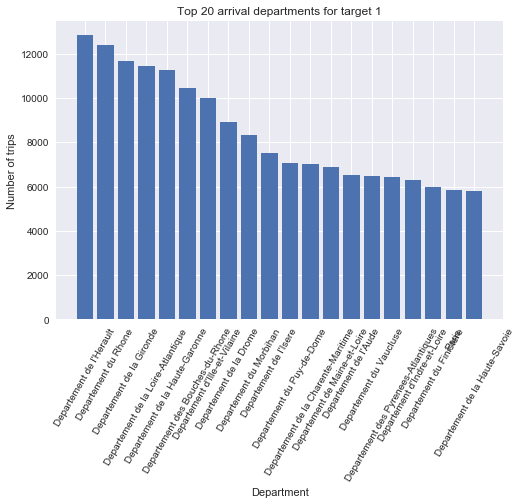

In [37]:
# Same for departments

def plot_top_departure_departments(N, target):
    x = np.arange(N)
    xTicks = data[data.target == target].departure_department.value_counts()[:N].index
    y = data[data.target == target].departure_department.value_counts()[:N].values
    plt.xticks(x, xTicks)
    plt.xticks(range(N), xTicks, rotation=60)
    plt.bar(x,y)
    plt.title('Top {} departure departments for target {}'.format(N, target))
    plt.xlabel('Department')
    plt.ylabel('Number of trips')
    plt.show()
    
def plot_top_arrival_departments(N, target):
    x = np.arange(N)
    xTicks = data[data.target == target].arrival_department.value_counts()[:N].index
    y = data[data.target == target].arrival_department.value_counts()[:N].values
    plt.xticks(x, xTicks)
    plt.xticks(range(N), xTicks, rotation=60)
    plt.bar(x,y)
    plt.title('Top {} arrival departments for target {}'.format(N, target))
    plt.xlabel('Department')
    plt.ylabel('Number of trips')    
    plt.show()
    
# Differences between success and failure from departure region?
plot_top_departure_departments(20, 0)
plot_top_departure_departments(20, 1)

# Differences between success and failure from departure region?
plot_top_arrival_departments(20, 0)
plot_top_arrival_departments(20, 1)

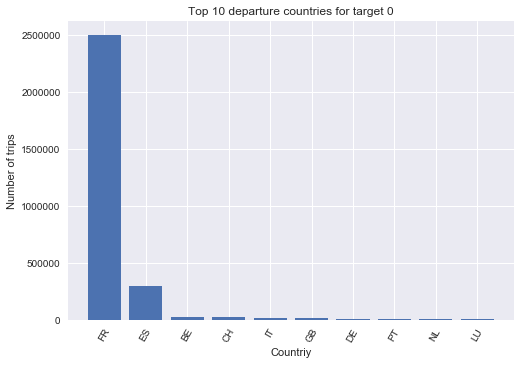

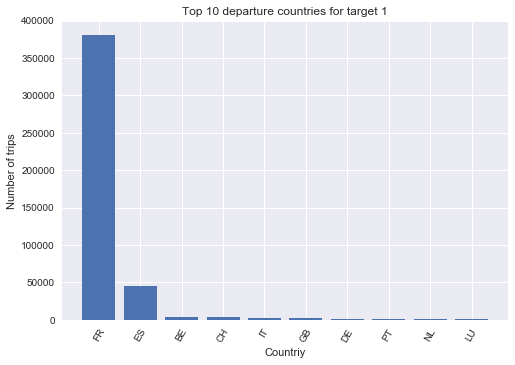

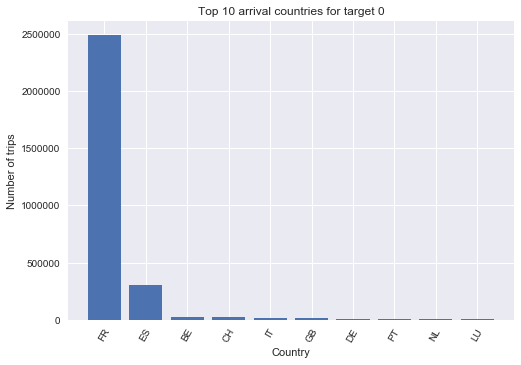

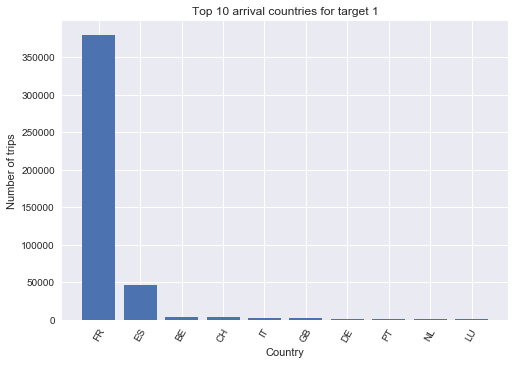

In [38]:
# Same for countries

def plot_top_departure_countries(N, target):
    x = np.arange(N)
    xTicks = data[data.target == target].departure_country.value_counts()[:N].index
    y = data[data.target == target].departure_country.value_counts()[:N].values
    plt.xticks(x, xTicks)
    plt.xticks(range(N), xTicks, rotation=60)
    plt.bar(x,y)
    plt.title('Top {} departure countries for target {}'.format(N, target))
    plt.xlabel('Countriy')
    plt.ylabel('Number of trips')
    plt.show()
    
def plot_top_arrival_countries(N, target):
    x = np.arange(N)
    xTicks = data[data.target == target].arrival_country.value_counts()[:N].index
    y = data[data.target == target].arrival_country.value_counts()[:N].values
    plt.xticks(x, xTicks)
    plt.xticks(range(N), xTicks, rotation=60)
    plt.bar(x,y)
    plt.title('Top {} arrival countries for target {}'.format(N, target))
    plt.xlabel('Country')
    plt.ylabel('Number of trips')    
    plt.show()
    
# Differences between success and failure from departure region?
plot_top_departure_countries(10, 0)
plot_top_departure_countries(10, 1)

# Differences between success and failure from departure region?
plot_top_arrival_countries(10, 0)
plot_top_arrival_countries(10, 1)

#### Effect of the City "usage index"

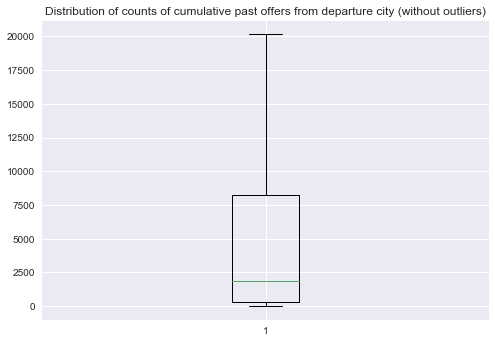

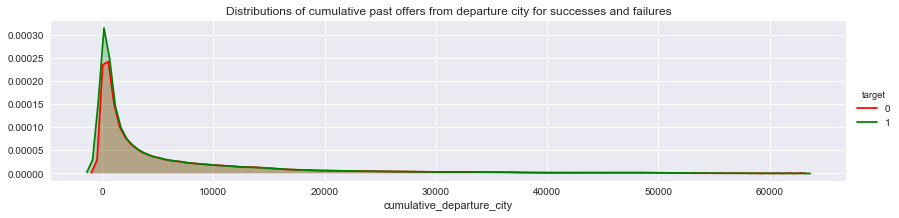

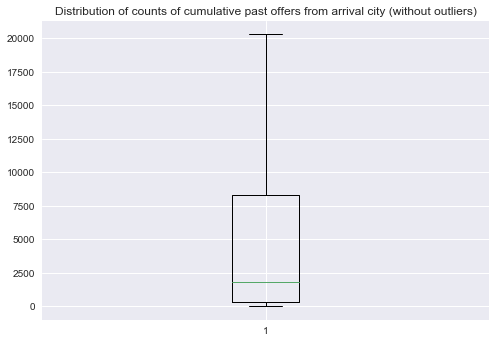

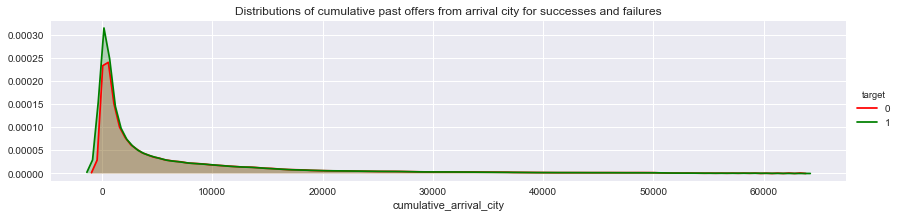

In [39]:
plt.boxplot(data.cumulative_departure_city, showfliers=False)
plt.title('Distribution of counts of cumulative past offers from departure city (without outliers)')
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'cumulative_departure_city',shade= True)
plt.title('Distributions of cumulative past offers from departure city for successes and failures')
facet.add_legend()
plt.show()

plt.boxplot(data.cumulative_arrival_city, showfliers=False)
plt.title('Distribution of counts of cumulative past offers from arrival city (without outliers)')
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'cumulative_arrival_city',shade= True)
plt.title('Distributions of cumulative past offers from arrival city for successes and failures')
facet.add_legend()
plt.show()

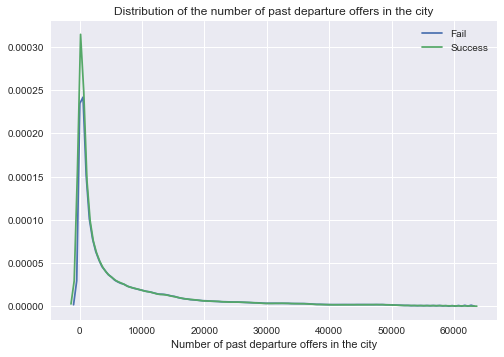

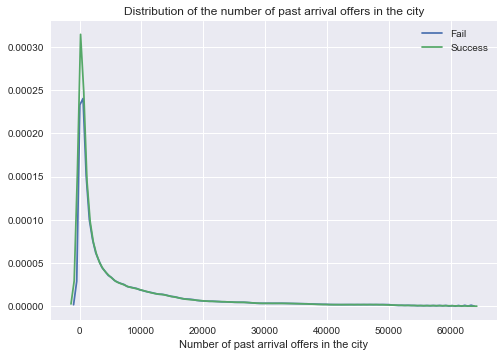

In [75]:
sns.kdeplot(data.cumulative_departure_city[data.target == 0], label='Fail')
sns.kdeplot(data.cumulative_departure_city[data.target == 1], label = 'Success')
plt.title('Distribution of the number of past departure offers in the city')
plt.xlabel('Number of past departure offers in the city')
# plt.xlim([-1000, 3000])
plt.show()

sns.kdeplot(data.cumulative_arrival_city[data.target == 0], label='Fail')
sns.kdeplot(data.cumulative_arrival_city[data.target == 1], label = 'Success')
plt.title('Distribution of the number of past arrival offers in the city')
plt.xlabel('Number of past arrival offers in the city')
# plt.xlim([-1000, 3000])
plt.show()

#### Effect of the department "usage index"

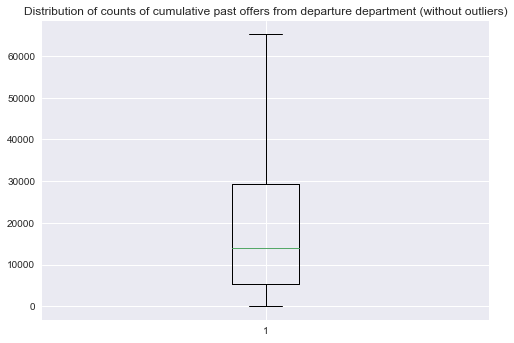

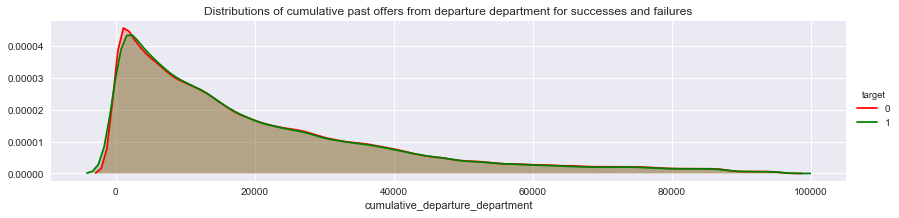

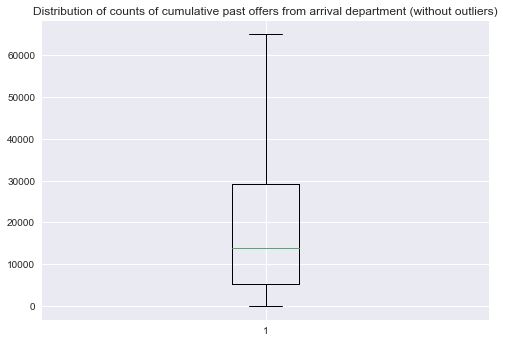

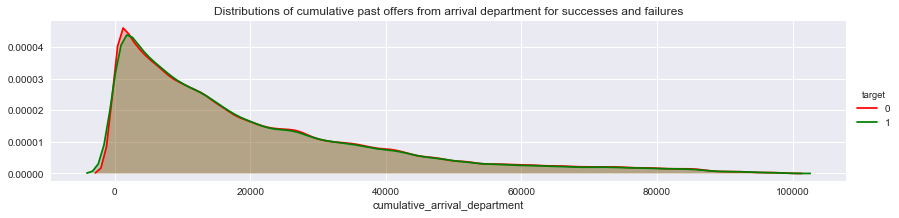

In [40]:
plt.boxplot(data.cumulative_departure_department, showfliers=False)
plt.title('Distribution of counts of cumulative past offers from departure department (without outliers)')
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'cumulative_departure_department',shade= True)
plt.title('Distributions of cumulative past offers from departure department for successes and failures')
facet.add_legend()
plt.show()

plt.boxplot(data.cumulative_arrival_department, showfliers=False)
plt.title('Distribution of counts of cumulative past offers from arrival department (without outliers)')
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'cumulative_arrival_department',shade= True)
plt.title('Distributions of cumulative past offers from arrival department for successes and failures')
facet.add_legend()
plt.show()

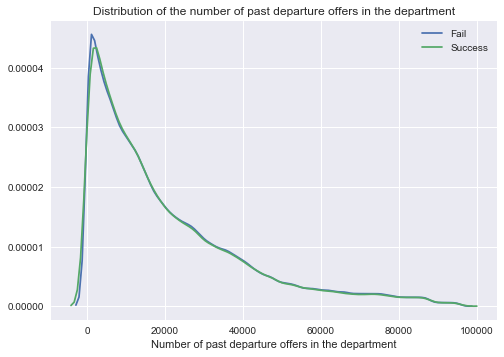

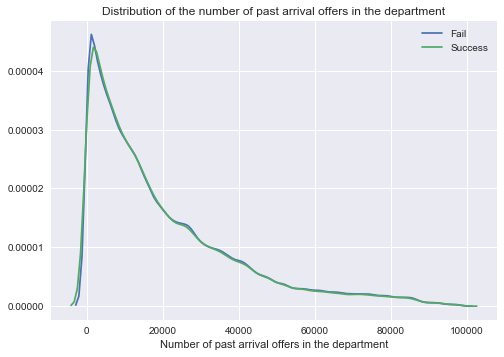

In [76]:
sns.kdeplot(data.cumulative_departure_department[data.target == 0], label='Fail')
sns.kdeplot(data.cumulative_departure_department[data.target == 1], label = 'Success')
plt.title('Distribution of the number of past departure offers in the department')
plt.xlabel('Number of past departure offers in the department')
# plt.xlim([-1000, 3000])
plt.show()

sns.kdeplot(data.cumulative_arrival_department[data.target == 0], label='Fail')
sns.kdeplot(data.cumulative_arrival_department[data.target == 1], label = 'Success')
plt.title('Distribution of the number of past arrival offers in the department')
plt.xlabel('Number of past arrival offers in the department')
# plt.xlim([-1000, 3000])
plt.show()

#### Effect of the region "usage index"

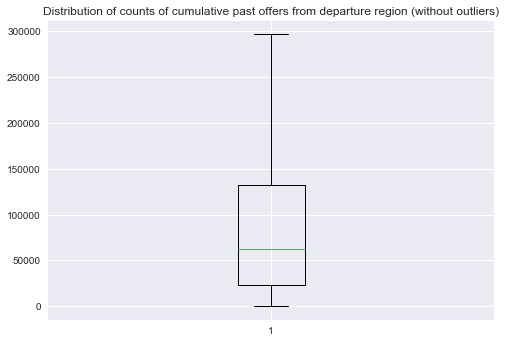

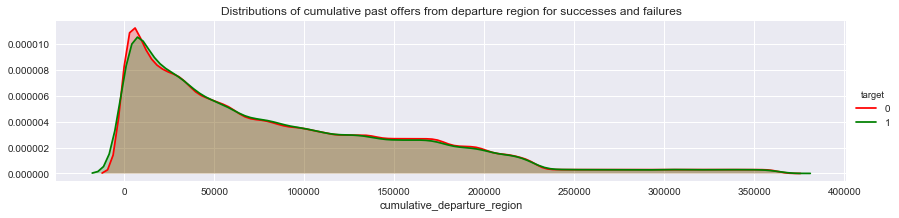

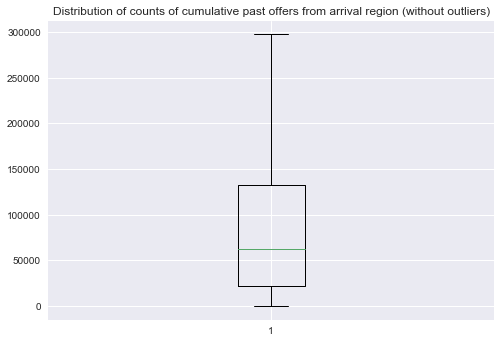

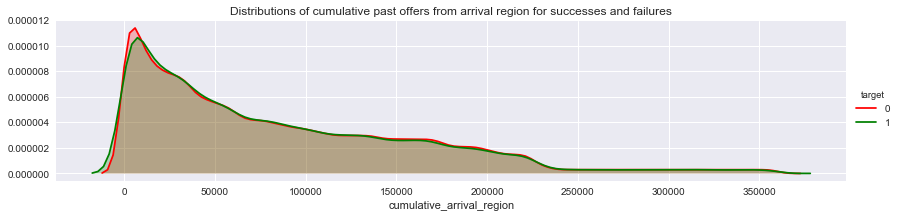

In [41]:
plt.boxplot(data.cumulative_departure_region, showfliers=False)
plt.title('Distribution of counts of cumulative past offers from departure region (without outliers)')
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'cumulative_departure_region',shade= True)
plt.title('Distributions of cumulative past offers from departure region for successes and failures')
facet.add_legend()
plt.show()

plt.boxplot(data.cumulative_arrival_region, showfliers=False)
plt.title('Distribution of counts of cumulative past offers from arrival region (without outliers)')
plt.show()

pal = ["r", "g"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'cumulative_arrival_region',shade= True)
plt.title('Distributions of cumulative past offers from arrival region for successes and failures')
facet.add_legend()
plt.show()

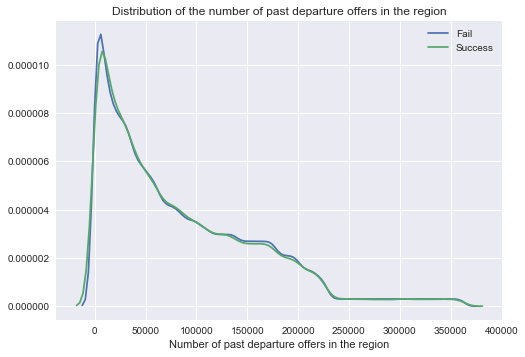

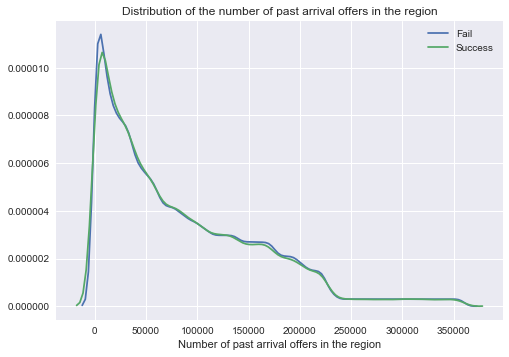

In [77]:
sns.kdeplot(data.cumulative_departure_region[data.target == 0], label='Fail')
sns.kdeplot(data.cumulative_departure_region[data.target == 1], label = 'Success')
plt.title('Distribution of the number of past departure offers in the region')
plt.xlabel('Number of past departure offers in the region')
# plt.xlim([-1000, 3000])
plt.show()

sns.kdeplot(data.cumulative_arrival_region[data.target == 0], label='Fail')
sns.kdeplot(data.cumulative_arrival_region[data.target == 1], label = 'Success')
plt.title('Distribution of the number of past arrival offers in the region')
plt.xlabel('Number of past arrival offers in the region')
# plt.xlim([-1000, 3000])
plt.show()

There is no straitghforward link between the intensity of the usage by the city, department or region on the success or failure of the offer.

In [78]:
data.columns

Index(['driver_id', 'offer_id', 'trip_id', 'trip_date', 'published_date',
       'signup_date', 'fixed_signup_country', 'is_main_trip',
       'unit_seat_price_eur', 'seat_offered_count', 'seat_left_count',
       'confirmed_seat_count', 'trip_distance_km', 'from_lat', 'from_lon',
       'to_lat', 'to_lon', 'is_comfort', 'is_auto_accept_mode',
       'publication_site_id', 'per_km_price', 'count_past_offers',
       'cumulative_distance', 'trip_date_year', 'trip_date_month',
       'trip_date_day', 'trip_date_hour', 'published_date_year',
       'published_date_month', 'published_date_day', 'signup_date_year',
       'signup_date_month', 'signup_date_day', 'signup_date_hour',
       'driver_maturity', 'time_laps', 'day_offer', 'day_trip',
       'departure_region', 'departure_department', 'departure_country',
       'departure_city', 'arrival_region', 'arrival_department',
       'arrival_country', 'arrival_city', 'target',
       'cumulative_departure_city', 'cumulative_arrival_city',

# Machine Learning

In [42]:
data.columns

Index(['driver_id', 'offer_id', 'trip_id', 'trip_date', 'published_date',
       'signup_date', 'fixed_signup_country', 'is_main_trip',
       'unit_seat_price_eur', 'seat_offered_count', 'seat_left_count',
       'confirmed_seat_count', 'trip_distance_km', 'from_lat', 'from_lon',
       'to_lat', 'to_lon', 'is_comfort', 'is_auto_accept_mode',
       'publication_site_id', 'per_km_price', 'count_past_offers',
       'cumulative_distance', 'trip_date_year', 'trip_date_month',
       'trip_date_day', 'trip_date_hour', 'published_date_year',
       'published_date_month', 'published_date_day', 'signup_date_year',
       'signup_date_month', 'signup_date_day', 'signup_date_hour',
       'driver_maturity', 'time_laps', 'day_offer', 'day_trip',
       'departure_region', 'departure_department', 'departure_country',
       'departure_city', 'arrival_region', 'arrival_department',
       'arrival_country', 'arrival_city', 'target',
       'cumulative_departure_city', 'cumulative_arrival_city',

In [43]:
continuous_features = ['unit_seat_price_eur', 'seat_offered_count', 'trip_distance_km', 
                       'driver_maturity', 'time_laps', 'count_past_offers', 
                       'cumulative_distance', 'cumulative_departure_city', 
                       'cumulative_arrival_city', 'cumulative_departure_department',
                      'cumulative_arrival_department', 'cumulative_departure_region',
                      'cumulative_arrival_region']
binary_features = ['is_main_trip', 'is_auto_accept_mode']
categorical_features = ['day_offer', 'day_trip',
       'departure_region', 'departure_department', 'departure_country',
       'departure_city', 'arrival_region', 'arrival_department',
       'arrival_country', 'arrival_city', 'fixed_signup_country', 'publication_site_id', 
        'trip_date_year','trip_date_month', 'trip_date_day', 'trip_date_hour',
       'published_date_year', 'published_date_month', 'published_date_day']

#### Creation of the X matrix

In [44]:
# Create categories for only main cities
main_cities = data.departure_city.value_counts()[:10]
data['departure_main_city'] = data['departure_city'].apply(lambda x: x if x in main_cities else 'small_city')

main_cities = data.arrival_city.value_counts()[:10]
data['arrival_main_city'] = data['arrival_city'].apply(lambda x: x if x in main_cities else 'small_city')

# Create categories for only main departments
main_cities = data.departure_department.value_counts()[:10]
data['departure_main_department'] = data['departure_department'].apply(lambda x: x if x in main_cities else 'small_department')

main_cities = data.arrival_department.value_counts()[:10]
data['arrival_main_department'] = data['arrival_department'].apply(lambda x: x if x in main_cities else 'small_department')

# Create categories for only main regions
main_cities = data.departure_region.value_counts()[:10]
data['departure_main_region'] = data['departure_region'].apply(lambda x: x if x in main_cities else 'small_region')

main_cities = data.arrival_region.value_counts()[:10]
data['arrival_main_region'] = data['arrival_region'].apply(lambda x: x if x in main_cities else 'small_region')

# Same for countries
main_cities = data.arrival_country.value_counts()[:10]
data['arrival_main_country'] = data['arrival_country'].apply(lambda x: x if x in main_cities else 'small_country')
main_cities = data.departure_country.value_counts()[:10]
data['departure_main_country'] = data['departure_country'].apply(lambda x: x if x in main_cities else 'small_country')


del main_cities

data['trip_year'] = data['trip_date_year'].apply(lambda x: 1 if x == '2015' else 0)

In [45]:
# Same for signup country, publication site id and trip hour
main_cities = data.fixed_signup_country.value_counts()[:10]
data['fixed_signup_country'] = data['fixed_signup_country'].apply(lambda x: x if x in main_cities else 'small_country')

main_cities = data.publication_site_id.value_counts()[:10]
data['publication_site_id'] = data['publication_site_id'].apply(lambda x: x if x in main_cities else 'small_publication_site')

main_cities = data.trip_date_hour.value_counts()[:10]
data['trip_date_hour'] = data['trip_date_hour'].apply(lambda x: x if x in main_cities else 'small_hour_time')

In [46]:
continuous_features = ['unit_seat_price_eur', 'seat_offered_count', 'trip_distance_km', 
                       'driver_maturity', 'time_laps', 'count_past_offers', 'cumulative_distance',
                      'cumulative_departure_city', 
                       'cumulative_arrival_city', 'cumulative_departure_department',
                      'cumulative_arrival_department', 'cumulative_departure_region',
                      'cumulative_arrival_region']
binary_features = ['is_main_trip', 'is_auto_accept_mode', 'trip_year']
categorical_features = ['day_offer', 'day_trip',
       'departure_main_region', 'departure_main_department', 'departure_main_country',
       'departure_main_city', 'arrival_main_region', 'arrival_main_department',
       'arrival_main_country', 'arrival_main_city', 'fixed_signup_country', 'publication_site_id',
       'trip_date_month', 'trip_date_hour', 'published_date_month']

In [47]:
count = 0
for feat in categorical_features:
    a = len(data[feat].value_counts())
    print(feat, a)
    count += a
count

day_offer 7
day_trip 7
departure_main_region 11
departure_main_department 11
departure_main_country 11
departure_main_city 11
arrival_main_region 11
arrival_main_department 11
arrival_main_country 11
arrival_main_city 11
fixed_signup_country 11
publication_site_id 11
trip_date_month 7
trip_date_hour 11
published_date_month 12


154

In [48]:
# Create pandas dataframe and add continuous variables after normalization
print('Normalizing continuous data')
X = data['unit_seat_price_eur']
# X = pd.DataFrame((X - X.mean()) / np.std(X))
for feat in continuous_features:
#     b = (data[feat] - data[feat].mean()) / np.std(data[feat])
    b = data[feat]
    X  = pd.concat((X, b), axis=1)

print('Adding dummy variables')
# Add binary variables
for feat in binary_features:
    X = pd.concat((X, data[feat]), axis=1)

print('Adding categorical variables')
# Add categorical variables
for feat in categorical_features:
    X = pd.concat((X, pd.get_dummies(data[feat], prefix=feat)), axis=1).iloc[:, :-1]
    print('Adding categorical variable {}'.format(feat))

Normalizing continuous data
Adding dummy variables
Adding categorical variables
Adding categorical variable day_offer
Adding categorical variable day_trip
Adding categorical variable departure_main_region
Adding categorical variable departure_main_department
Adding categorical variable departure_main_country
Adding categorical variable departure_main_city
Adding categorical variable arrival_main_region
Adding categorical variable arrival_main_department
Adding categorical variable arrival_main_country
Adding categorical variable arrival_main_city
Adding categorical variable fixed_signup_country
Adding categorical variable publication_site_id
Adding categorical variable trip_date_month
Adding categorical variable trip_date_hour
Adding categorical variable published_date_month


In [49]:
print(X.shape)
y = data.target

(3361282, 156)


In [50]:
X.columns.tolist()

['unit_seat_price_eur',
 'unit_seat_price_eur',
 'seat_offered_count',
 'trip_distance_km',
 'driver_maturity',
 'time_laps',
 'count_past_offers',
 'cumulative_distance',
 'cumulative_departure_city',
 'cumulative_arrival_city',
 'cumulative_departure_department',
 'cumulative_arrival_department',
 'cumulative_departure_region',
 'cumulative_arrival_region',
 'is_main_trip',
 'is_auto_accept_mode',
 'trip_year',
 'day_offer_0',
 'day_offer_1',
 'day_offer_2',
 'day_offer_3',
 'day_offer_4',
 'day_offer_5',
 'day_trip_0',
 'day_trip_1',
 'day_trip_2',
 'day_trip_3',
 'day_trip_4',
 'day_trip_5',
 'departure_main_region_Aquitaine',
 'departure_main_region_Brittany',
 'departure_main_region_Centre',
 'departure_main_region_Ile-de-France',
 'departure_main_region_Languedoc-Roussillon',
 'departure_main_region_Midi-Pyrenees',
 'departure_main_region_Pays de la Loire',
 'departure_main_region_Poitou-Charentes',
 "departure_main_region_Provence-Alpes-Cote d'Azur",
 'departure_main_region_Rho

In [51]:
dataset = pd.concat((X, y), axis=1)

#### Save the dataset

In [52]:
dataset.to_csv('clean_dataset_3.csv', sep=';', encoding='utf-8')

In [53]:
dataset.shape

(3361282, 156)